<a href="https://colab.research.google.com/github/o-bollverk/msf/blob/main/msf_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing packages and version checks

In [ ]:
from urllib.request import urlopen
from fastai.vision import *
from fastai.metrics import error_rate
from PIL import Image
#from google.colab import drive
from os import listdir
import numpy as np 
import cv2
from matplotlib import image
from matplotlib import pyplot
import numpy as np
import warnings
import pandas as pd
import os 
import torch
from fastai.vision.data import *
import fastai
from pathlib import Path
from shutil import copyfile
import random
import shutil
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image
from datetime import datetime


##### Check that you have exactly these versions of the packages (otherwise some augmentations won't work):
Fastai 1.0.61
tensorflow               2.3.0               
tensorflow-addons        0.11.2              
tensorflow-datasets      4.1.0               
tensorflow-estimator     2.3.0               
tensorflow-hub           0.10.0              
tensorflow-metadata      0.25.0              

When running the fastai cells twice, you can get an error that numpy object has no attribute func. In that case, run the package import cell again.

This notebook was run on a GTX 1080 with Ryzen 2600x on Ubuntu 20.04 with Nvidia drivers selected.

In [ ]:
print(fastai.__version__)

In [ ]:
!  pip3 list | grep tensorflow

tensorflow               2.3.0               
tensorflow-addons        0.11.2              
tensorflow-datasets      4.1.0               
tensorflow-estimator     2.3.0               
tensorflow-hub           0.10.0              
tensorflow-metadata      0.25.0              


# Cloning the repository

### These are the plane classes to be predicted, selected from Microsoft Flight Simulator

Classes:

Airbus A320neo

Boeing 747-8 Intercontinental

Aviat Pitts Special S2S

Cub Crafter X Cub

Daher TBM 930

Diamond DA40NG

Diamond DA62

EXTRA 330LT



https://www.windowscentral.com/list-microsoft-flight-simulator-planes


In [ ]:
# Clone the entire repo.
!git clone -l -s git://github.com/o-bollverk/msf cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 4517, done.
remote: Counting objects: 100% (4517/4517), done.
remote: Compressing objects: 100% (4124/4124), done.


In [ ]:
# ! git pull

Correspondence table for folder names:

In [ ]:
nimede_vastavus = pd.DataFrame({"web_name": np.sort(listdir("all_data_color/")),
                                "game_name": np.sort(np.unique([x.split("_clear")[0] for x in listdir("msf_data/image_data_clear")]))})
nimede_vastavus

,web_name,game_name
0,airbus_color,airbus
1,aviat s2s_color,aviat
2,boeing 747_color,boeing
3,cessna 152_color,cessna_152
4,cessna 172_color,cessna_172
5,cessna 208_color,cessna_208
6,cessna cj4_color,cessna_cj
7,cub crafters xcub_color,cubcraft
8,daher tbm 930_color,daher
9,diamond da40_color,diamond40ng


# Random selection of data from unbalanced set and folder creation

In [ ]:
! mkdir random_selection_train
! mkdir random_selection_test

# For deleting directories
#shutil.rmtree("random_selection_test")
#shutil.rmtree("random_selection_train")

In [ ]:
# creating temporary folder for selected files

#2/3 web data
#1/3 data captured in game

selection_size_web = 250
selection_size_web_test = int(0.2*selection_size_web)

def abifun(x):
    return x[:len(nimede_vastavus.game_name[i])] == nimede_vastavus.game_name[i]
 
for i in range(nimede_vastavus.shape[0]):
  web_files = listdir("all_data_color/" + nimede_vastavus.web_name[i])
  game_files_clear = listdir("msf_data/image_data_clear/")    
  game_files_clear_selected = np.array(game_files_clear)[[abifun(x) for x in game_files_clear]]
  game_files_rainy = listdir("msf_data/image_data_rainy/")
  game_files_rainy_selected = np.array(game_files_rainy)[[abifun(x) for x in game_files_rainy]]
  
  # making a random selection

  selected_web = random.sample(web_files, selection_size_web)
  selected_web2 = ["all_data_color/" + nimede_vastavus.web_name[i] + "/" + x for x in selected_web]
  selected_web2_test = selected_web2[0:int(selection_size_web_test)]
  selected_web2_train = selected_web2[int(selection_size_web_test):]

  selected_clear = random.sample(set(game_files_clear_selected), int(selection_size_web/4))
  selected_clear2 = ["msf_data/image_data_clear/" + x for x in selected_clear]
  selected_clear2_test = selected_clear2[0:int(len(selected_clear)*0.2)]
  selected_clear2_train = selected_clear2[int(len(selected_clear)*0.2):]

  selected_rainy = random.sample(set(game_files_rainy_selected), int(selection_size_web/4))
  selected_rainy2 = ["msf_data/image_data_rainy/" + x for x in selected_rainy]
  selected_rainy2_test = selected_rainy2[0:int(len(selected_rainy)*0.2)]
  selected_rainy2_train = selected_rainy2[int(len(selected_rainy)*0.2):]
  
  complete_selection_train = np.concatenate([selected_web2_train, selected_clear2_train, selected_rainy2_train])
  complete_selection_test = np.concatenate([selected_web2_test, selected_clear2_test, selected_rainy2_test])

  os.mkdir("random_selection_train/" +  nimede_vastavus.game_name[i])
  for filename in complete_selection_train:
    shutil.copy(filename, "random_selection_train/" +  nimede_vastavus.game_name[i])

  os.mkdir("random_selection_test/" +  nimede_vastavus.game_name[i])
  for filename in complete_selection_test:
    shutil.copy(filename, "random_selection_test/" +  nimede_vastavus.game_name[i])



# Training and evaluating the model on non-augmented data

In [ ]:
warnings.filterwarnings('ignore')

train_directory = "random_selection_train"
test_directory = "random_selection_test"

path = Path(train_directory)
np.random.seed(42)
data =  ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
                                    ds_tfms=get_transforms(),
         size=224, num_workers=4).normalize(imagenet_stats)


In [ ]:
data.classes

['airbus',
 'aviat',
 'boeing',
 'cessna_152',
 'cessna_172',
 'cessna_208',
 'cessna_cj',
 'cubcraft',
 'daher',
 'diamond40ng',
 'diamondda62',
 'extra']

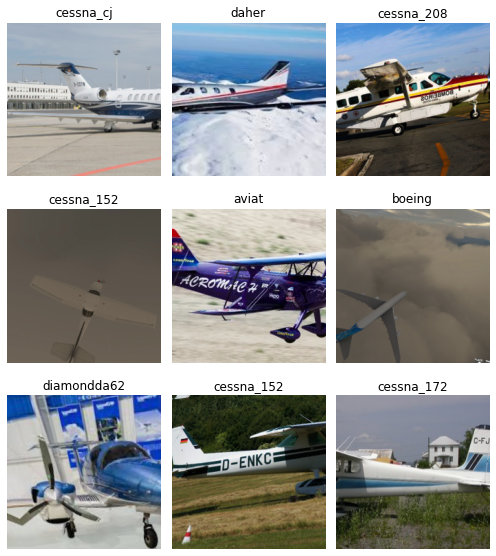

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['airbus',
  'aviat',
  'boeing',
  'cessna_152',
  'cessna_172',
  'cessna_208',
  'cessna_cj',
  'cubcraft',
  'daher',
  'diamond40ng',
  'diamondda62',
  'extra'],
 12,
 2151,
 537)

In [ ]:
# !jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## Resnet 18

### Train model

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/revilo/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.fit_one_cycle(15)

epoch,train_loss,valid_loss,accuracy,time
0,3.413944,1.834352,0.394786,00:10
1,2.418430,1.116181,0.633147,00:10
2,1.792817,1.054370,0.655493,00:10
3,1.369845,0.935247,0.674115,00:10
4,1.160519,0.904503,0.689013,00:10
5,0.948665,0.821740,0.729981,00:10
6,0.801217,0.830267,0.737430,00:10
7,0.719413,0.765799,0.756052,00:10
8,0.632739,0.728349,0.748603,00:10
9,0.587102,0.702056,0.767225,00:10


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

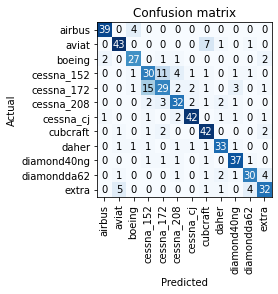

In [ ]:
interp.plot_confusion_matrix()

Accuracy on seperate test set

In [ ]:
warnings.filterwarnings('ignore')

tulemused = []
correct_labels = []
for i in listdir("random_selection_test"):
  for j in listdir("random_selection_test" + "/" + i):
    correct_labels.append(i)
    img = open_image("random_selection_test/" + i +"/" + j)
    pred_class,pred_idx,outputs = learn.predict(img)
    vastus = data.classes[int(pred_class)]
    tulemused = np.append(tulemused, vastus)

accuracy = sum(tulemused == correct_labels)/len(correct_labels)

print("Accuracy: " + str(accuracy))


Accuracy: 0.7577777777777778


## Resnet 34

### Train model

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(15)

epoch,train_loss,valid_loss,accuracy,time
0,3.413944,1.834352,0.394786,00:10
1,2.418430,1.116181,0.633147,00:10
2,1.792817,1.054370,0.655493,00:10
3,1.369845,0.935247,0.674115,00:10
4,1.160519,0.904503,0.689013,00:10
5,0.948665,0.821740,0.729981,00:10
6,0.801217,0.830267,0.737430,00:10
7,0.719413,0.765799,0.756052,00:10
8,0.632739,0.728349,0.748603,00:10
9,0.587102,0.702056,0.767225,00:10


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

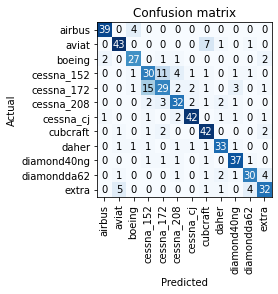

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
warnings.filterwarnings('ignore')

tulemused = []
correct_labels = []
for i in listdir("random_selection_test"):
  for j in listdir("random_selection_test" + "/" + i):
    correct_labels.append(i)
    img = open_image("random_selection_test/" + i +"/" + j)
    pred_class,pred_idx,outputs = learn.predict(img)
    vastus = data.classes[int(pred_class)]
    tulemused = np.append(tulemused, vastus)

accuracy = sum(tulemused == correct_labels)/len(correct_labels)

print("Accuracy: " + str(accuracy))


Accuracy: 0.7577777777777778


In [ ]:
predictions = pd.DataFrame({"correct": correct_labels, "prediction": tulemused}).sort_values("correct")
predictions[predictions.correct != predictions.prediction]

,correct,prediction
1596,airbus,extra
1599,airbus,daher
1600,airbus,boeing
1603,airbus,cessna_172
1606,airbus,cessna_cj
...,...,...
1458,extra,cubcraft
1452,extra,daher
1449,extra,diamondda62
1444,extra,daher


## Resnet 50

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(15)

epoch,train_loss,valid_loss,accuracy,time
0,2.566219,1.224577,0.584730,00:16
1,1.711831,1.019902,0.702048,00:14
2,1.273870,1.056013,0.728119,00:14
3,1.057649,0.912550,0.737430,00:14
4,0.879219,0.820335,0.752328,00:14
5,0.732129,0.793133,0.774674,00:14
6,0.615853,0.707924,0.787709,00:14
7,0.513118,0.679085,0.800745,00:14
8,0.442249,0.621615,0.819367,00:14
9,0.371021,0.622294,0.824953,00:14


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

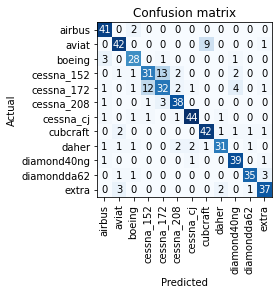

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
warnings.filterwarnings('ignore')

tulemused = []
correct_labels = []
for i in listdir("random_selection_test"):
  for j in listdir("random_selection_test" + "/" + i):
    correct_labels.append(i)
    img = open_image("random_selection_test/" + i +"/" + j)
    pred_class,pred_idx,outputs = learn.predict(img)
    vastus = data.classes[int(pred_class)]
    tulemused = np.append(tulemused, vastus)

accuracy = sum(tulemused == correct_labels)/len(correct_labels)
predictions_resnet50 = pd.DataFrame({"correct": correct_labels, "prediction": tulemused}).sort_values("correct")

print("Accuracy: " + str(accuracy))


Accuracy: 0.8022222222222222


## Adding image augmentation (creating separate folders)

### Wrap, mean, random hsv and rotation augmentation functions. Function for augmented folder creation

In [ ]:
# Transformation functions
#img_raw = tf.io.read_file(input_folder + folder_name + filename)
      
def median_transform(img_raw):
      img = tf.io.decode_image(img_raw)
      #img = tf.image.convert_image_dtype(tf.expand_dims(img, 0), tf.dtypes.float32)
      img = tf.image.convert_image_dtype(img, tf.dtypes.float32)
      #img = tf.image.resize(img, [500,500])
      mean = tfa.image.mean_filter2d(img, filter_shape=5)
#     mean = tfa.image.median_filter2d(img, filter_shape=5)
      return mean

def wrap_transform(img_raw):
      img = tf.io.decode_image(img_raw)
      input_img = tf.image.convert_image_dtype(tf.expand_dims(img, 0), tf.dtypes.float32)
      flow_shape = [1, input_img.shape[1], input_img.shape[2], 2]
      init_flows = np.float32(np.random.normal(size=flow_shape) * 2.0)
      dense_img_warp = tfa.image.dense_image_warp(input_img, init_flows)
      dense_img_warp = tf.squeeze(dense_img_warp, 0)
      return dense_img_warp

def random_hsv(img_raw):
    img = tf.io.decode_image(img_raw)
    #img = tf.image.convert_image_dtype(tf.expand_dims(img, 0), tf.dtypes.float32)
    delta = 0.5
    lower_saturation = 0.1
    upper_saturation = 0.9
    lower_value = 0.2
    upper_value = 0.8
    delta = 0.5
#    saturation = 0.3
    value = 0.6
    #adj_hsvinyiq = tfa.image.adjust_hsv_in_yiq(img, delta, saturation, value)

    rand_hsvinyiq = tfa.image.random_hsv_in_yiq(img, delta, lower_saturation, upper_saturation, lower_value, upper_value)
    return rand_hsvinyiq
    #return adj_hsvinyiq

def rotate(img_raw):
    img = tf.io.decode_image(img_raw)
    #img = img_raw
    img = tf.image.convert_image_dtype(img, tf.float32)
    rotated = tfa.image.rotate(img, tf.constant(np.pi/8))
    return rotated

#input_img = tf.image.convert_image_dtype(tf.expand_dims(img, 0), tf.dtypes.float32)



In [ ]:
# With the entire training set and training after that:
# No resizing at this point

def image_folder_filter(input_folder, output_folder, method):
  
  input_folder = input_folder + "/"
  output_folder = output_folder + "/"
  folders = listdir(input_folder)
  if os.path.isdir(output_folder) == False:
    try: 
      os.mkdir(output_folder)
    except OSError:
      print("Creation of the directory '" + output_folder + "' failed")

  for folder_name in folders:
    folder_name = folder_name + "/"
    files_in_folder = listdir(input_folder + folder_name)

    if os.path.isdir(output_folder + folder_name) == False:
      try: 
        os.mkdir(output_folder + folder_name)
      except OSError:
        print("Creation of the directory '" + output_folder + folder_name + "' failed")

    for filename in files_in_folder:
      img_raw = tf.io.read_file(input_folder + folder_name + filename)
      if method == "median":
        transformed_result = median_transform(img_raw)
      elif method == "wrap":
        transformed_result = wrap_transform(img_raw)
      elif method == "random_hsv":
        transformed_result = random_hsv(img_raw)
      elif method == "rotate":
        transformed_result = rotate(img_raw)

      tf.keras.preprocessing.image.save_img( output_folder + folder_name + filename, transformed_result)


In [ ]:
# Creating a folder for each augmentation - test and train separate
# In total it should take about 15 minutes

print(datetime.now(tz=None))

image_folder_filter("random_selection_train", "random_selection_train_mean", method = "median")
image_folder_filter("random_selection_test", "random_selection_test_mean", method = "median")
image_folder_filter("random_selection_train", "random_selection_train_wrap", method = "wrap")
image_folder_filter("random_selection_test", "random_selection_test_wrap", method = "wrap")
image_folder_filter("random_selection_train", "random_selection_train_rotate", method = "rotate")
image_folder_filter("random_selection_test", "random_selection_test_rotate", method = "rotate")
image_folder_filter("random_selection_train", "random_selection_train_random_hsv", method = "random_hsv")
image_folder_filter("random_selection_test", "random_selection_test_random_hsv", method = "random_hsv")

print(datetime.now(tz=None))


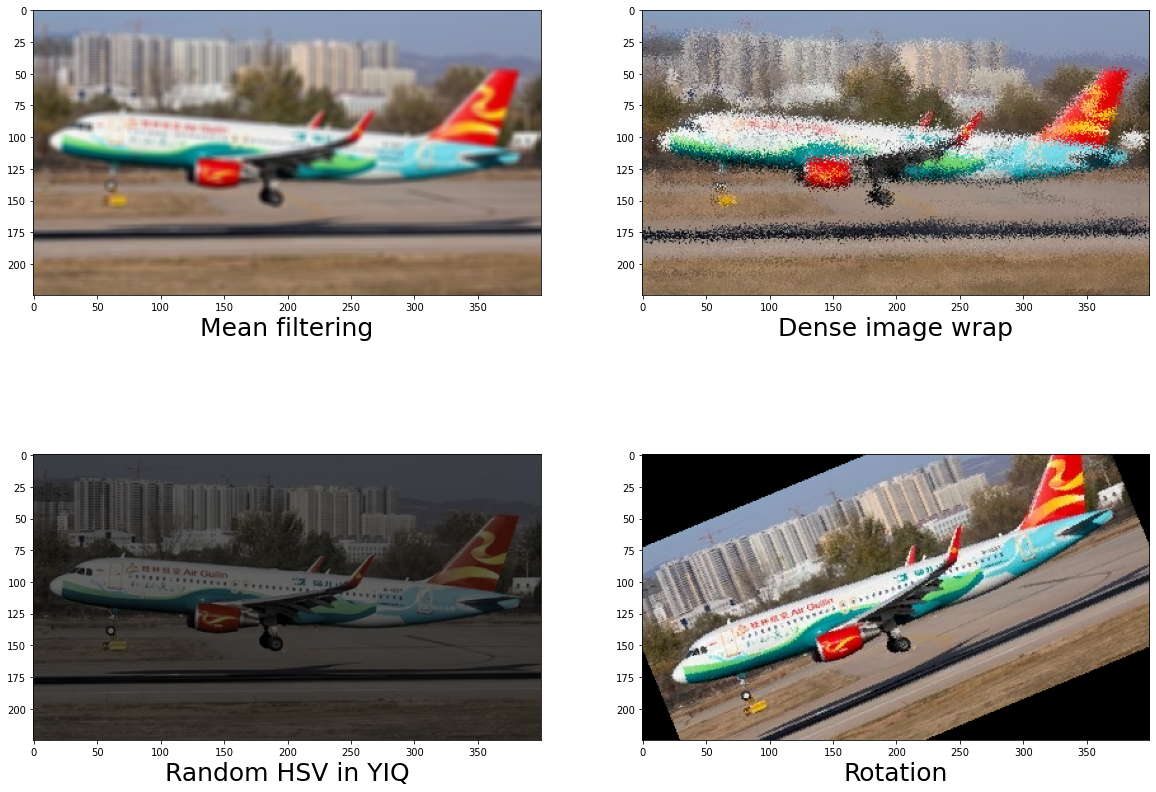

In [ ]:
# a visualization of what each filter looks like
test_read = tf.io.read_file("random_selection_train/airbus/" + os.listdir("random_selection_train/airbus/")[0])

images_list = [median_transform(test_read),
wrap_transform(test_read),
random_hsv(test_read),
rotate(test_read)]

titles = ["Mean filtering", "Dense image wrap", "Random HSV in YIQ", "Rotation"]

veerge = 2
fig, axs = plt.subplots(2, veerge, figsize = (20, 15))
counter = -1

for row in axs:
  for col in row:
      counter = counter + 1
      col.imshow(images_list[counter]) 
      col.set_xlabel(titles[counter])
      col.xaxis.label.set_size(25)


# Training and evaluating on augmented data 

### Mean filtering (giving pixels values based on values from its neighbouring pixels)

In [ ]:
train_directory = "random_selection_train_mean"
test_directory = "random_selection_test_mean"

path = Path(train_directory)


epoch,train_loss,valid_loss,accuracy,time
0,3.515014,2.189034,0.256983,00:09
1,2.765982,1.401943,0.530726,00:09
2,2.204252,1.250506,0.594041,00:10
3,1.822099,1.222702,0.595903,00:10
4,1.561497,1.175943,0.625698,00:09
5,1.383150,1.094783,0.636872,00:09
6,1.239066,0.992713,0.661080,00:09
7,1.127971,0.962593,0.675978,00:09
8,0.991697,0.942426,0.683426,00:09
9,0.910652,0.897427,0.707635,00:09


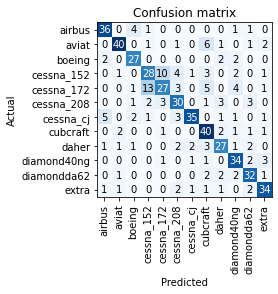

In [ ]:
warnings.filterwarnings('ignore')

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(15)

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

In [ ]:
warnings.filterwarnings('ignore')

tulemused = []
correct_labels = []
image_locs = []

for i in listdir(test_directory):
  for j in listdir(test_directory + "/" + i):
    image_loc = test_directory + "/" + i +"/" + j
    image_locs.append(image_loc)
    correct_labels.append(i)
    img = open_image(test_directory + "/" + i +"/" + j)
    pred_class,pred_idx,outputs = learn.predict(img)
    vastus = data.classes[int(pred_class)]
    tulemused = np.append(tulemused, vastus)

accuracy = sum(tulemused == correct_labels)/len(correct_labels)

print("Accuracy: " + str(accuracy))

predictions = pd.DataFrame({"correct": correct_labels, "prediction": tulemused})
predictions_mean = predictions

predictions[predictions.correct != predictions.prediction]


Accuracy: 0.6922222222222222


,correct,prediction
0,daher,cessna_cj
1,daher,cessna_cj
2,daher,cessna_172
7,daher,extra
9,daher,cessna_152
...,...,...
1775,aviat,cubcraft
1776,aviat,extra
1778,aviat,diamondda62
1779,aviat,diamond40ng


### Dense Image wrap 

In [ ]:
train_directory = "random_selection_train_wrap"
test_directory = "random_selection_test_wrap"

path = Path(train_directory)


epoch,train_loss,valid_loss,accuracy,time
0,3.576658,2.316593,0.240223,00:10
1,2.938118,1.918000,0.407821,00:09
2,2.481285,1.793071,0.459963,00:09
3,2.135488,1.663538,0.471136,00:10
4,1.884569,1.528901,0.491620,00:10
5,1.701301,1.402190,0.525140,00:10
6,1.551656,1.374028,0.543762,00:10
7,1.425022,1.349500,0.547486,00:10
8,1.326590,1.326231,0.543762,00:10
9,1.268681,1.327581,0.540037,00:10


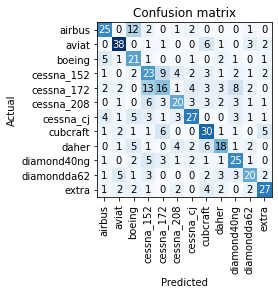

In [ ]:
warnings.filterwarnings('ignore')

learn = cnn_learner(data, models.resnet18, metrics=accuracy)

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(10)

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

In [ ]:
warnings.filterwarnings('ignore')

tulemused = []
correct_labels = []
image_locs = []

for i in listdir(test_directory):
  for j in listdir(test_directory + "/" + i):
    image_loc = test_directory + "/" + i +"/" + j
    image_locs.append(image_loc)
    correct_labels.append(i)
    img = open_image(test_directory + "/" + i +"/" + j)
    pred_class,pred_idx,outputs = learn.predict(img)
    vastus = data.classes[int(pred_class)]
    tulemused = np.append(tulemused, vastus)

accuracy = sum(tulemused == correct_labels)/len(correct_labels)

print("Accuracy: " + str(accuracy))

predictions = pd.DataFrame({"correct": correct_labels, "prediction": tulemused})
predictions_wrap = predictions


### Random HSV augmentation

In [ ]:
train_directory = "random_selection_train_random_hsv"
test_directory = "random_selection_test_random_hsv"

path = Path(train_directory)


epoch,train_loss,valid_loss,accuracy,time
0,3.406599,2.020753,0.329609,00:09
1,2.610694,1.379757,0.543762,00:09
2,1.986822,1.236608,0.612663,00:09
3,1.676657,1.101345,0.661080,00:09
4,1.413042,1.086731,0.631285,00:09
5,1.191492,1.009810,0.662942,00:09
6,1.031604,1.004796,0.685289,00:09
7,0.936241,0.914836,0.702048,00:09
8,0.841135,0.891021,0.703911,00:10
9,0.774590,0.862548,0.698324,00:10


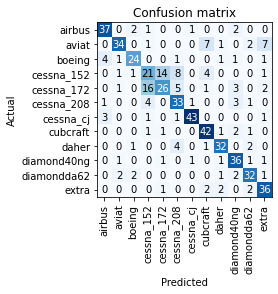

In [ ]:
warnings.filterwarnings('ignore')

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(15)

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

In [ ]:
warnings.filterwarnings('ignore')

tulemused = []
correct_labels = []
image_locs = []

for i in listdir(test_directory):
  for j in listdir(test_directory + "/" + i):
    image_loc = test_directory + "/" + i +"/" + j
    image_locs.append(image_loc)
    correct_labels.append(i)
    img = open_image(test_directory + "/" + i +"/" + j)
    pred_class,pred_idx,outputs = learn.predict(img)
    vastus = data.classes[int(pred_class)]
    tulemused = np.append(tulemused, vastus)

accuracy = sum(tulemused == correct_labels)/len(correct_labels)

print("Accuracy: " + str(accuracy))

predictions = pd.DataFrame({"correct": correct_labels, "prediction": tulemused})
predictions_random_hsv = predictions


### Rotation augmentation

In [ ]:
train_directory = "random_selection_train_rotate"
test_directory = "random_selection_test_rotate"

path = Path(train_directory)

data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
learn = cnn_learner(data, models.resnet18, metrics=accuracy)


epoch,train_loss,valid_loss,accuracy,time
0,3.453691,2.142250,0.297952,00:09
1,2.715079,1.496685,0.540037,00:10
2,2.146326,1.326272,0.599628,00:10
3,1.773962,1.232724,0.616387,00:09
4,1.527245,1.162831,0.638734,00:09
5,1.317075,1.037154,0.679702,00:09
6,1.159178,0.988393,0.685289,00:09
7,1.042326,0.969855,0.690875,00:10
8,0.946467,0.936210,0.702048,00:09
9,0.870955,0.905543,0.713222,00:09


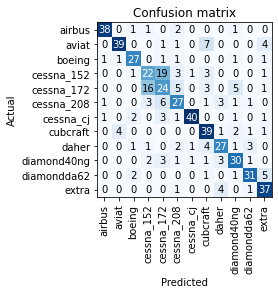

In [ ]:
warnings.filterwarnings('ignore')

np.random.seed(42)

learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(15)
1
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

In [ ]:
warnings.filterwarnings('ignore')

tulemused = []
correct_labels = []
image_locs = []

for i in listdir(test_directory):
  for j in listdir(test_directory + "/" + i):
    image_loc = test_directory + "/" + i +"/" + j
    image_locs.append(image_loc)
    correct_labels.append(i)
    img = open_image(test_directory + "/" + i +"/" + j)
    pred_class,pred_idx,outputs = learn.predict(img)
    vastus = data.classes[int(pred_class)]
    tulemused = np.append(tulemused, vastus)

accuracy = sum(tulemused == correct_labels)/len(correct_labels)

print("Accuracy: " + str(accuracy))

predictions = pd.DataFrame({"correct": correct_labels, "prediction": tulemused})
predictions_rotation = predictions


## Background eliminated data (train-test ratio 60/40)

###  Resnet18 with background elimination

In [ ]:
train_directory = "random_selection_augmented_jpg/random_selection_train"
test_directory = "random_selection_augmented_jpg/random_selection_test"

path = Path(train_directory)


epoch,train_loss,valid_loss,accuracy,time
0,3.387519,1.867044,0.400372,00:09
1,2.499635,1.207170,0.614525,00:09
2,1.925120,0.996594,0.687151,00:09
3,1.574966,0.969666,0.696462,00:09
4,1.363513,0.925704,0.707635,00:10
5,1.189132,0.865105,0.726257,00:09
6,1.019918,0.818784,0.748603,00:10
7,0.890879,0.767536,0.770950,00:09
8,0.795950,0.752654,0.769088,00:09
9,0.744268,0.717643,0.765363,00:09


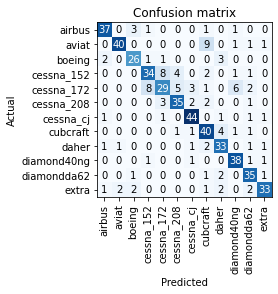

In [ ]:
warnings.filterwarnings('ignore')

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(15)

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

In [ ]:
warnings.filterwarnings('ignore')

tulemused = []
correct_labels = []
image_locs = []

for i in listdir(test_directory):
  for j in listdir(test_directory + "/" + i):
    image_loc = test_directory + "/" + i +"/" + j
    image_locs.append(image_loc)
    correct_labels.append(i)
    img = open_image(test_directory + "/" + i +"/" + j)
    pred_class,pred_idx,outputs = learn.predict(img)
    vastus = data.classes[int(pred_class)]
    tulemused = np.append(tulemused, vastus)

accuracy = sum(tulemused == correct_labels)/len(correct_labels)

print("Accuracy: " + str(accuracy))

predictions = pd.DataFrame({"correct": correct_labels, "prediction": tulemused})
predictions_background = predictions


### Resnet 34 with background elimination

In [ ]:
train_directory = "random_selection_augmented_jpg/random_selection_train"
test_directory = "random_selection_augmented_jpg/random_selection_test"

path = Path(train_directory)


epoch,train_loss,valid_loss,accuracy,time
0,3.357168,1.834051,0.404097,00:10
1,2.476012,1.191099,0.612663,00:09
2,1.894464,1.020440,0.666667,00:09
3,1.568658,1.052135,0.664804,00:09
4,1.316894,0.909801,0.715084,00:09
5,1.119941,0.877265,0.713222,00:09
6,0.986686,0.847934,0.741155,00:09
7,0.897962,0.747678,0.756052,00:09
8,0.815138,0.740945,0.757914,00:10
9,0.744333,0.714376,0.782123,00:09


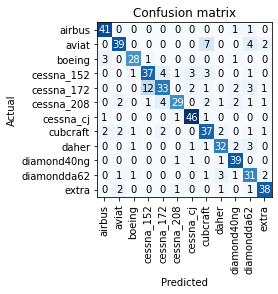

In [ ]:
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.fit_one_cycle(15)

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

In [ ]:
warnings.filterwarnings('ignore')

tulemused = []
correct_labels = []
image_locs = []

for i in listdir(test_directory):
  for j in listdir(test_directory + "/" + i):
    image_loc = test_directory + "/" + i +"/" + j
    image_locs.append(image_loc)
    correct_labels.append(i)
    img = open_image(test_directory + "/" + i +"/" + j)
    pred_class,pred_idx,outputs = learn.predict(img)
    vastus = data.classes[int(pred_class)]
    tulemused = np.append(tulemused, vastus)

accuracy = sum(tulemused == correct_labels)/len(correct_labels)

print("Accuracy: " + str(accuracy))

predictions = pd.DataFrame({"correct": correct_labels, "prediction": tulemused})
predictions_background_rs34 = predictions


## Visualizing misclassified examples (background elimination)

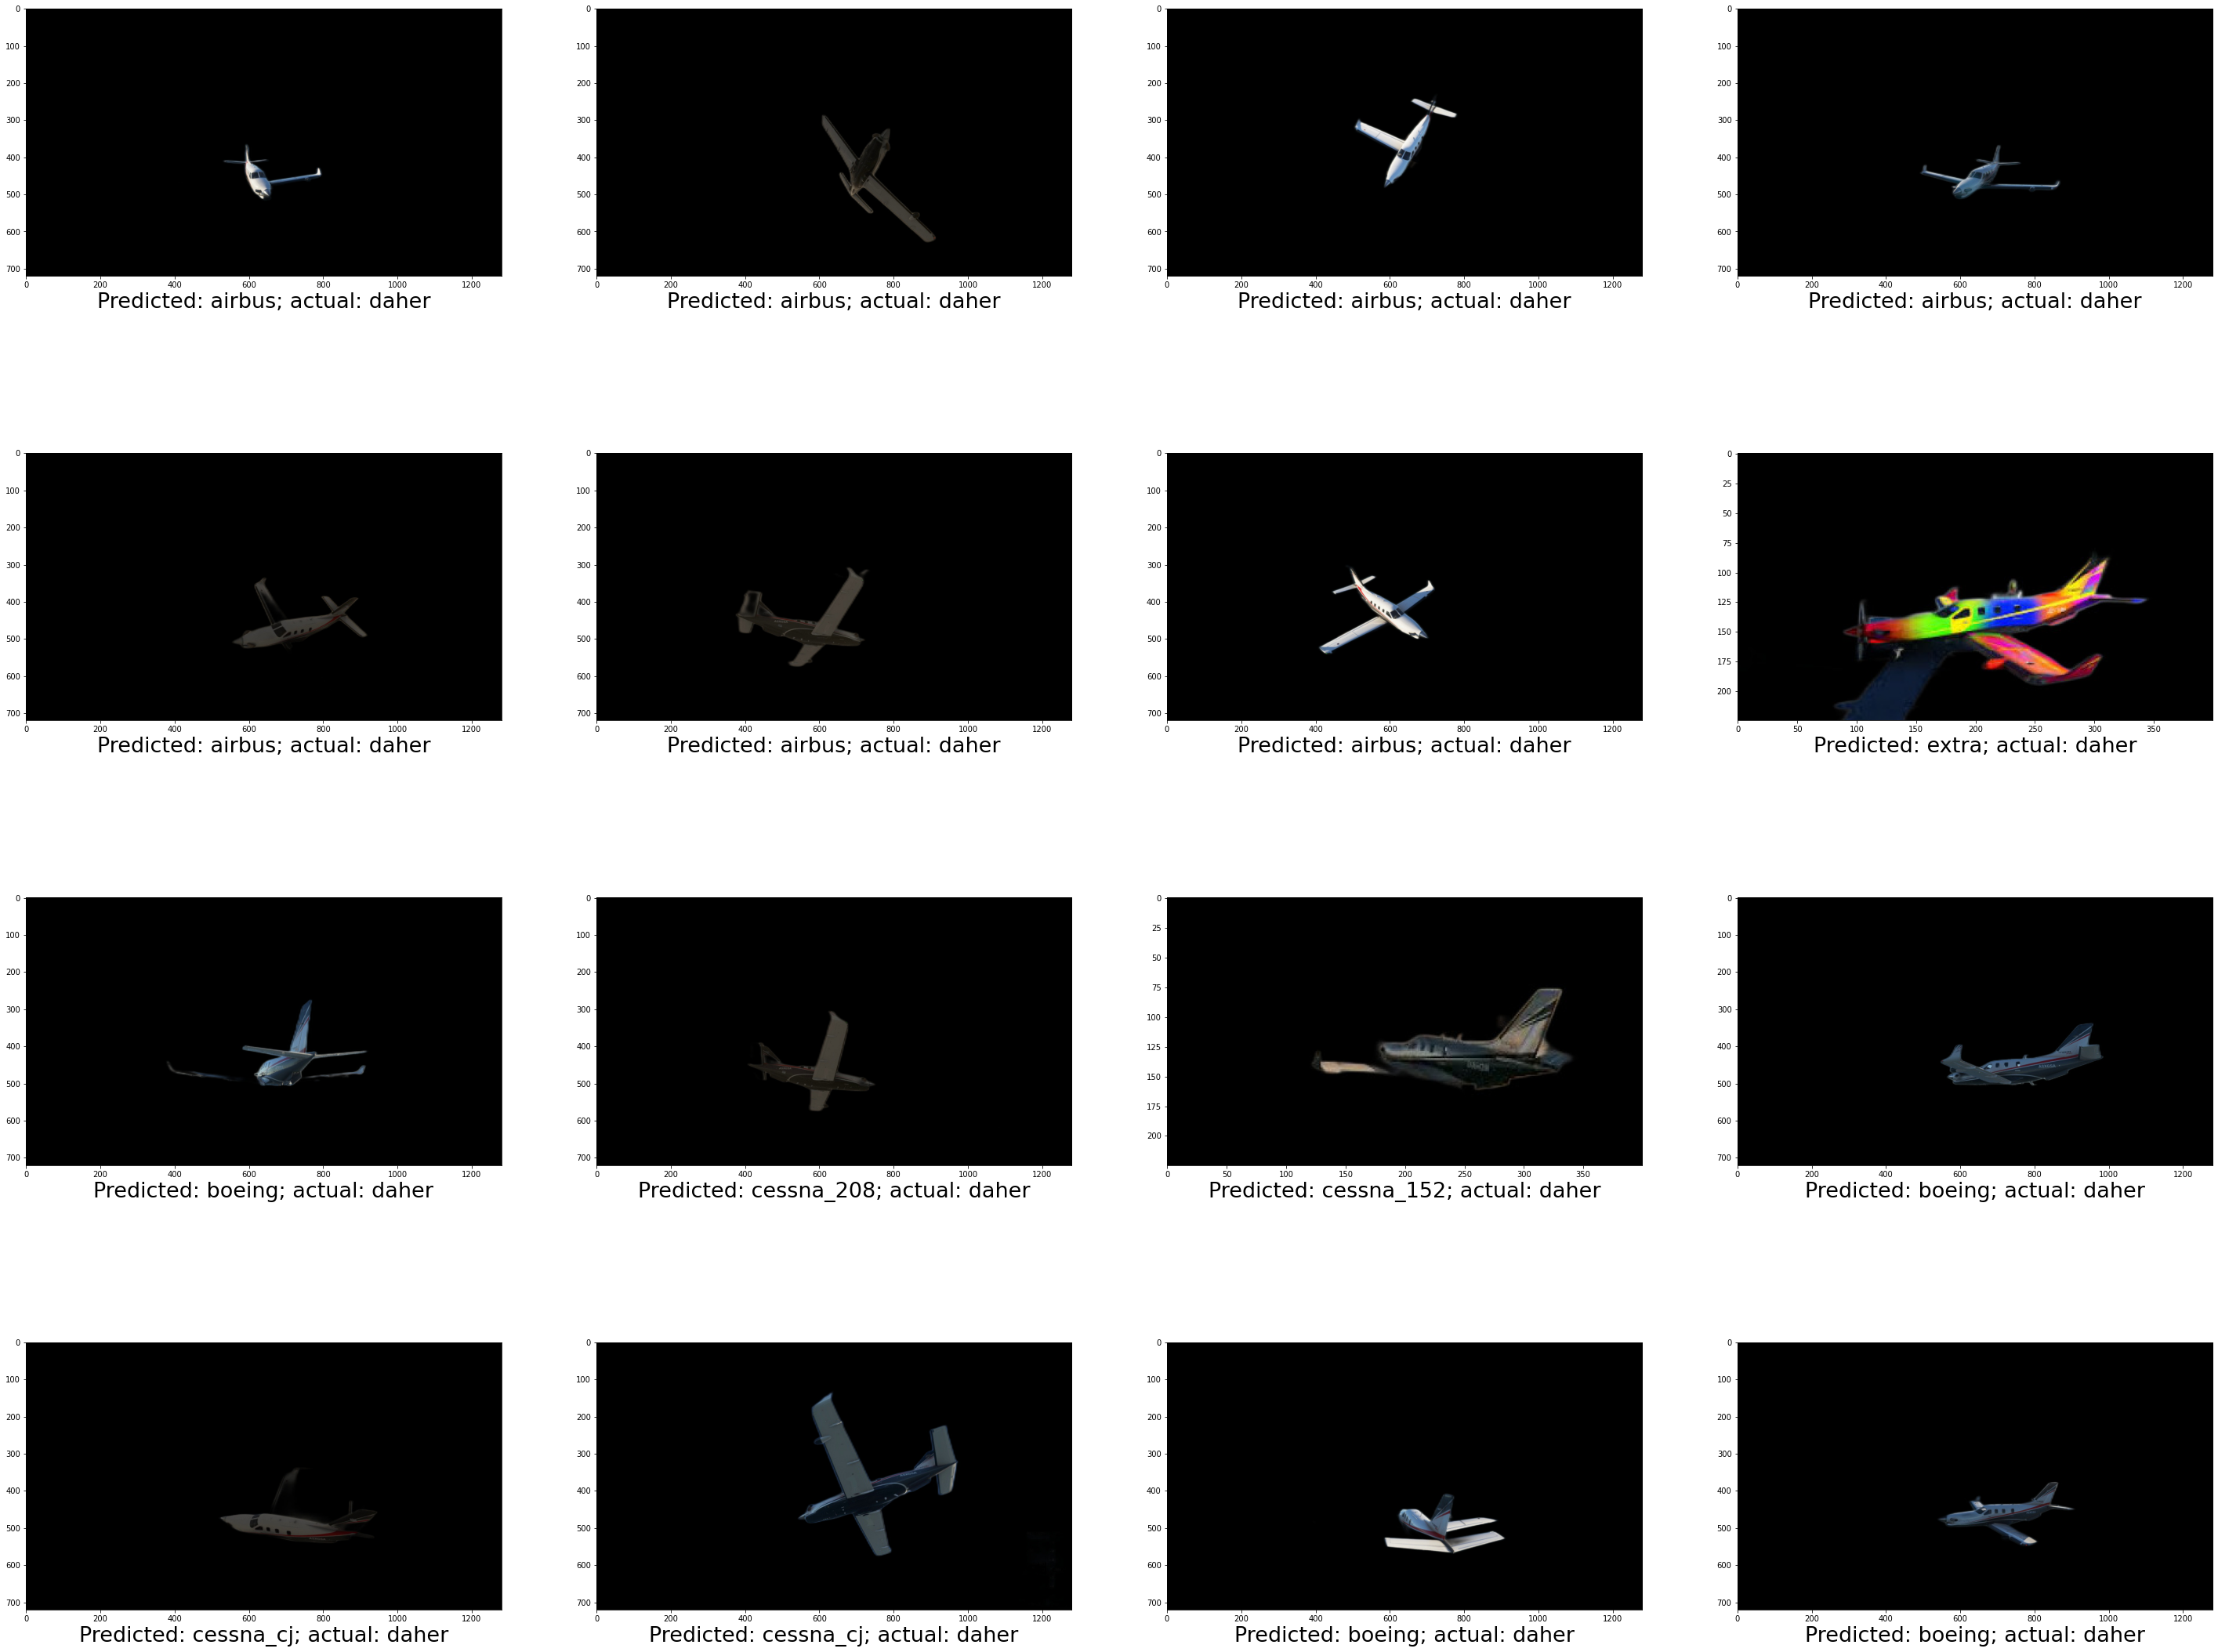

In [ ]:

veerge = 4
ridu = 4
fig, axs = plt.subplots(ridu, veerge, figsize = (50, 40))
counter = -1
predictions_wrong = predictions[predictions.correct != predictions.prediction]

for row in axs:
  for col in row:
      counter = counter + 1
      col.imshow(Image.open(np.array(image_locs)[tulemused != correct_labels][counter]))     
      col.set_xlabel("Predicted: " + predictions_wrong.iloc[counter,:].prediction + "; actual: " + predictions_wrong.iloc[counter,].correct)
      col.xaxis.label.set_size(27)